In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata

from matplotlib.colors import LogNorm

In [ ]:
x1 = np.load('x_05_1_new85.npy')
y1 = np.load('y_05_1_new85.npy')
F1 = np.load('F_05_1_new85.npy')

x1iso = np.load('x_iso_05_new85.npy')
y1iso = np.load('y_iso_05_new85.npy')

x1last = np.load('x_last_05_new85.npy')
y1last = np.load('y_last_05_new85.npy')

x2 = np.load('x_05_2_new85.npy')
y2 = np.load('y_05_2_new85.npy')
F2 = np.load('F_05_2_new85.npy')

x = np.zeros(len(x1)+len(x2))
y = np.zeros(len(y1)+len(y2))
F = np.zeros(len(F1)+len(F2))

D = 16.4e6*3.08e18

Mbh = 2e33*6.5e9
G = 6.67e-8
c = 3e10
rg = G*Mbh/c**2
if (x1last[0] != x1last[-1]) or (y1last[0] != y1last[-1]):
    x1last = np.append(x1last, x1last[0])
    y1last = np.append(y1last, y1last[0])


In [20]:
for i in range(len(x1)):
    x[i] = x1[i]/D*206265*1e6
    y[i] = y1[i]/D*206265*1e6
    x1[i] = x1[i]/D*206265*1e6
    y1[i] = y1[i]/D*206265*1e6
    F[i] = F1[i]*100
    F1[i] = F1[i]*100
for i in range(len(x2)):
    x[len(x1)+i] = x2[i]/D*206265*1e6
    y[len(x1)+i] = y2[i]/D*206265*1e6
    x2[i] = x2[i]/D*206265*1e6
    y2[i] = y2[i]/D*206265*1e6
    F[len(x1)+i] = F2[i]*100
    F2[i] = F2[i]*100
for i in range(len(x1last)):
    x1last[i] = x1last[i]/D*206265*1e6
    y1last[i] = y1last[i]/D*206265*1e6

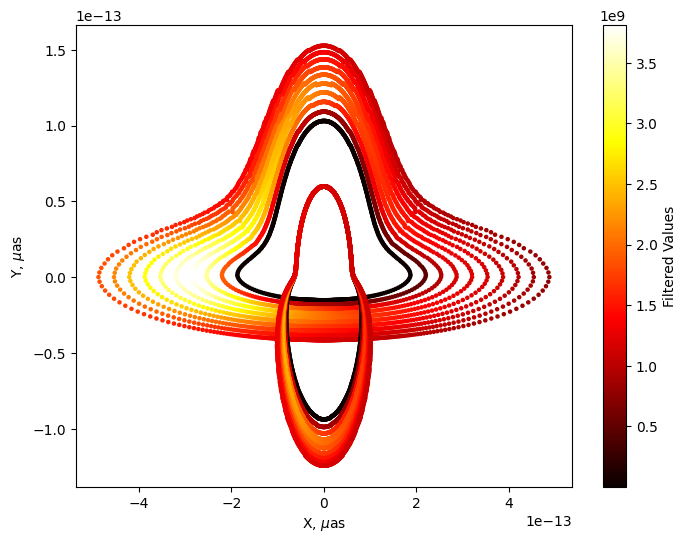

9.760750524736824e-16
2.7745193884816314e-16


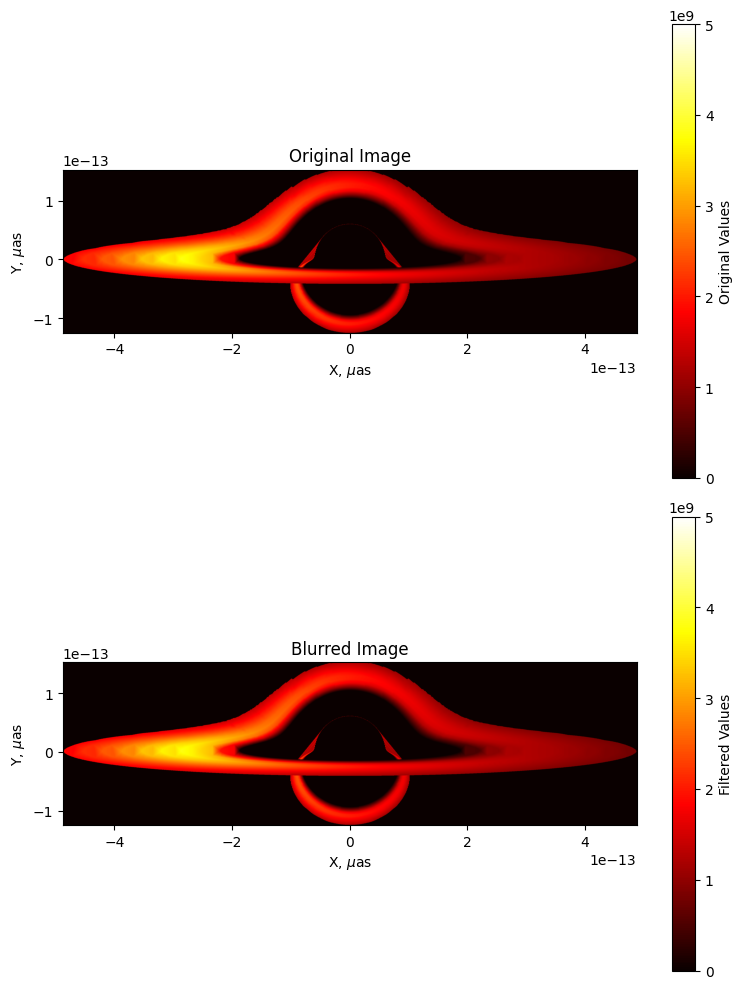

In [21]:
plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=F, cmap='hot', s=5)

# Добавляем цветовую шкалу
plt.colorbar(label='Filtered Values')

# Метки осей и заголовок
plt.xlabel(r"X, $\mu$as")
plt.ylabel(r"Y, $\mu$as")

# Показать финальный результат
plt.show()



grid_x, grid_y = np.mgrid[min(x):max(x):1000j, min(y):max(y):1000j]

# Интерполяция с использованием кубической интерполяции
grid_F1 = griddata((x1, y1), F1, (grid_x, grid_y), method='linear')
grid_F2 = griddata((x2, y2), F2, (grid_x, grid_y), method='linear')


from matplotlib.path import Path

# Создаём объект Path по точкам границы
boundary_path = Path(np.column_stack((x1last, y1last)))

# Создаём сетку координат
points = np.column_stack((grid_x.ravel(), grid_y.ravel()))

# Определяем, какие точки внутри границы
mask_inside = boundary_path.contains_points(points).reshape(grid_x.shape)

masked_F1 = np.where(mask_inside, grid_F1, 0)

grid_F = np.where(masked_F1<1e7, grid_F2, masked_F1)


grid_F = np.nan_to_num(grid_F, nan=0.0)


# Маска для данных с NaN


# Применение фильтра Гаусса с режимом "reflect"

# Вычисление поля зрения
fov_x = max(x) - min(x)  # поле зрения по оси x
fov_y = max(y) - min(y)  # поле зрения по оси y

# Вычисление сигма с учётом меньшего размера поля зрения
sigma = 1 / 12 * min(fov_x, fov_y)

grid_F_blurred = gaussian_filter(grid_F, sigma=sigma, mode='reflect')

# Применение маски к результирующему изображению


print(grid_x[1, 0] - grid_x[0, 0])  # шаг по оси x
print(grid_y[0, 1] - grid_y[0, 0])  # шаг по оси y




# Построение исходного и размытого изображения

fig, axes = plt.subplots(2, 1, figsize=(8, 10))


# Исходное изображение
vmin = 0
vmax = 5e9
im1 = axes[0].imshow(grid_F.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='hot', vmin=vmin, vmax=vmax)

# Исходное изображение
aspect_ratio = fov_x / fov_y

axes[0].set_title('Original Image')

axes[0].set_xlabel(r"X, $\mu$as")
axes[0].set_ylabel(r"Y, $\mu$as")
fig.colorbar(im1, ax=axes[0], label='Original Values')

# Размытое изображение
im2 = axes[1].imshow(grid_F_blurred.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='hot', vmin=vmin, vmax=vmax)

# Размытое изображение
axes[1].set_title('Blurred Image')

axes[1].set_xlabel(r"X, $\mu$as")
axes[1].set_ylabel(r"Y, $\mu$as")
fig.colorbar(im2, ax=axes[1], label='Filtered Values')

plt.tight_layout()
plt.show()